In [1]:
import xlrd
import matplotlib
# matplotlib.use('TkAgg')   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# from mpl_toolkits.basemap import Basemap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from pyquery import PyQuery as pq

In [2]:
All_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
                   'Connecticut', 'Delaware', 'Dist. of Col.', 
                   'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 
                   'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 
                   'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
                   'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
                   'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 
                   'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
                   'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
                   'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
                   'Wyoming']
WC = ('Washington', 'Oregon', 'California', 'Nevada', 'Arizona', 'Alaska', 'Hawaii')
RM = ('Montana', 'Idaho', 'Wyoming', 'Utah', 'Colorado')
GC = ('New Mexico',  'Texas', 'Arkansas', 'Louisiana',  'Mississippi', 'Alabama')
Midwest = ('North Dakota',  'South Dakota', 'Nebraska',  'Kansas', 'Oklahoma', 
           'Minnesota', 'Iowa', 'Missouri', 'Wisconsin', 'Illinois', 'Indiana', 'Kentucky',
           'Michigan',  'Tennessee', 'Ohio')

East = ('Florida',  'Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'West Virginia', 
              'Maryland',  'Delaware',  'Pennsylvania',  'New Jersey',  'New York',  'Connecticut', 
              'Rhode Island',  'Vermont',  'New Hampshire',  'Massachusetts',  'Maine', 'Dist. of Col.')
state_regions = [East, Midwest, GC, RM, WC]
Region = ["East Coast", "Midwest", "Gulf Coast", "Rocky Mountain", "West Coast"]
price_url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=EMM_EPM0_PTE_R10_DPG&f=W'
import_url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WTTIM_R10-Z00_2&f=W'
stock_url = 'https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=WCESTP11&f=W'
population_path = './population/nst-est2018-01.xlsx'

In [3]:
def preprocess(string):
    '''
    Change the type from string to list and remove redundant ''
    Args:
        string: (str) string loaded from pyquery
    Return:
        data: (list) 
    '''
    assert isinstance(string, str)
    string = string.replace(',', '').replace('.', '').replace('NA', '0').split(' ')
    
    return list(filter(lambda a: a != '', string))
    
def url2df(url, name):
    '''
    use pyquery to crawl the data and convert it to pandas.dataframe
    Args:
        url: (str) website url for crawling
        name: (str) the name of the data
    Return:
        data: (DataFrame) 
    '''
    assert isinstance(url, str)
    assert isinstance(name, str)
    html_doc = pq(url)
    html_doc.contents()
    
    value = ".B3:nth-child(3)"
    date = ".B6"
    
    value_data = preprocess(html_doc(value).text())
    value_data = list(map(int, value_data))
    date_data = preprocess(html_doc(date).text())    
    data = pd.DataFrame(value_data, columns = [name], index = date_data)
    return data

def url2df_im(url, name):
    '''
    use pyquery to crawl the data and convert it to pandas.dataframe
    Args:
        url: (str) website url for crawling
        name: (str) the name of the data
    Return:
        data: (DataFrame) 
    '''
    assert isinstance(url, str)
    assert isinstance(name, str)
    html_doc = pq(url)
    html_doc.contents()
    
    value = ".B3:nth-child(3)"
    date = ".B6"
    
    value_data = preprocess(html_doc(value).text())
    value_data = [value_data[0]] + value_data
    value_data =  list(map(int, value_data))
    date_data = preprocess(html_doc(date).text())    
    data = pd.DataFrame(value_data, columns = [name], index = date_data)
    return data

def url2np(url, name):
    '''
    use pyquery to crawl the data and convert it to numpy array
    Args:
        url: (str) website url for crawling
        name: (str) the name of the data
    Return:
        data: (numpy array) 
    '''
    assert isinstance(url, str)
    assert isinstance(name, str)
    html_doc = pq(url)
    html_doc.contents()
    
    value = ".B3"
    date = ".B5"
    
    value_data = preprocess(html_doc(value).text())
    value_data = list(map(int, value_data))
    date_data = preprocess(html_doc(date).text())    
    array = np.array([date_data, value_data])
    return array

def dict2df(dic):
    '''
    Transform a dictionary object to dataframe
    Args:
        dic: (dictionary)
    Return: 
        df: (DataFrame)
    '''
    assert isinstance(dic, dict)
    df = pd.DataFrame()
    for name, url in dic.items():
        df = pd.concat([df, url2df(url, name)], axis = 1)
    return df

def dict2df_im(dic):
    '''
    Transform a dictionary object to dataframe, while dealing with the edge case on `import`
    Args: 
        dic: (dictionary)
    Return: 
        df: (DataFrame)
    '''
    assert isinstance(dic, dict)
    df = pd.DataFrame()
    for name, url in dic.items():
        df = pd.concat([df, url2df_im(url, name)], axis = 1)
    return df

def get_correlate(df_price, df_factor):
    '''
    Retuen the correlation of two df.dataframe
    Args:
        df_price: (pd.DataFrame)
        df_factor: (pd.DataFrame)
    Return:
        coor: (dict)
    '''
    assert isinstance(df_price, pd.DataFrame)
    assert isinstance(df_factor, pd.DataFrame)
    coor = {}
    for i, r in enumerate(Region):
        price_array = normalized(df_price[[r]].values)
        factor_array = normalized(df_factor[[r]].values)        
        min_length = min([price_array.shape[0], factor_array.shape[0]])
        price_array, factor_array = price_array[-min_length:], factor_array[-min_length:]
        coor[r] = np.correlate(price_array.squeeze() , factor_array.squeeze())/min_length
    return coor

def normalized(numpydata):
    '''
    Normalized the numpy array.
    Args:
        numpydata: (nparray)
    '''
    assert isinstance(numpydata, np.ndarray)
    max_ = np.max(numpydata)
    min_ = np.min(numpydata)
    return (numpydata-min_)/(max_-min_)

def name_process(array):
    '''
    preprocess the naming conflict between two object
    '''
    assert isinstance(array, np.ndarray)
    out = []
    for i, region in enumerate(state_regions):
        out.append(array.item().get(region))
    return out

def create_heatmap(coor_dict, cmap, tit):
    '''
    Create the heapmap of correlation between factors and the fossil prices.
    For more color map, please check: https://matplotlib.org/examples/color/colormaps_reference.html
    Args:
        coor_dict: (dict)
        cmap: the colormap type
        title: (str) i.e. 'Correlation between price and import in different region'
    '''
    assert isinstance(coor_dict, dict)
    assert isinstance(tit, str)
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.readshapefile('./shape/st99_d00','states',drawbounds=True)
    ATOLL_CUTOFF = 0.005
    colors={}
    statenames=[]
    vmin = min(coor_dict.items(), key=lambda x: x[1])[1]
    vmax= max(coor_dict.items(), key=lambda x: x[1])[1]
    # vmin = 0; vmax = 1
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in ['District of Columbia','Puerto Rico']:
            value = coor_dict[statename]
            colors[statename] = cmap((value-vmin)/(vmax-vmin))[:3]
        statenames.append(statename)
    ax = plt.gca() # get current axes instance
    fig = plt.gcf()
    for nshape,seg in enumerate(m.states):
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]]) 
            poly = Polygon(seg,facecolor=color,edgecolor='black')
            ax.add_patch(poly)
    for i, shapedict in enumerate(m.states_info):
    #fill the color for hawaii and Alaska
        if shapedict['NAME'] not in ['Puerto Rico', 'District of Columbia']:
    # Translate the noncontiguous states:
            if shapedict['NAME'] in ['Alaska', 'Hawaii']:
                seg = m.states[int(shapedict['SHAPENUM'] - 1)]
                # maintain the information of 8 main islands of Hawaii, rescale
                if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
                    seg = list(map(lambda xy: ((xy[0] + 5500000)*0.8, 0.8*(xy[1]-1200000)), seg))
                # Rescale Alaska
                elif shapedict['NAME'] == 'Alaska':
                    seg = list(map(lambda xy: (0.33*xy[0] + 1100000, 0.33*xy[1]-1300000), seg))
        
            color = rgb2hex(colors[shapedict['NAME']]) 
            poly = Polygon(seg, facecolor=color, edgecolor='black', linewidth=0.8)
            ax.add_patch(poly)
    plt.title(tit)
    cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap, orientation='horizontal')
    plt.show() 

def create_corr_map(corr_dict):
    '''
    create the dictionary suitable for mapping to the US map
    Args:
        corr_dict: (dictionary) 
    Return:
        corr_map: (dictionary)
    '''
    assert isinstance(corr_dict, dict)
    corr_map = {}
    for i, region in enumerate(state_regions):
        for state in region:
            corr_map[state] = corr_dict[Region[i]][0]
    return corr_map

def downsample(df, start_year, end_year):
    '''
    Downsample the pandas.dataframe to the data in some period of years.
    Args:
        df: (pandas.dataframe)
        start_year: (int)
        end_year: (int)
    Return:
        df_price_down: (pandas.dataframe)
    '''
    assert isinstance(df, pd.DataFrame)
    assert start_year >= df.index.year[0]
    assert end_year <= df.index.year[-1]
    # df.index = pd.to_datetime(df.index)
    df_tmp = df_price.groupby(df.index.year).transform('mean')
    df_price_down = df_tmp.iloc[(df_tmp.index.month == 2) & (df_tmp.index.year >= start_year) & (df_tmp.index.year <= end_year)]
    return df_price_down

def corr_bar(import_cor,vehicle_cor,pop_cor):
    '''
    plot the bar chart of correlation
    Args:
        import_cor:(dictionary)
        pop_cor:(dictionary)
        vehicle:(dictionary)
        
    '''
    assert isinstance(import_cor, dict)
    assert isinstance(pop_cor, dict)
    assert isinstance(vehicle_cor, dict)
    imp_value,vhc_value,pop_value=[],[],[]
    region_name,region_name2,region_name3=[],[],[]

    # for reg, val in import_cor.items():
    for reg in Region:
        region_name.append(reg)
        imp_value.append(round(import_cor[reg][0],3))
        region_name2.append(reg)
        vhc_value.append(round(vehicle_cor[reg][0],3))
        region_name3.append(reg)
        pop_value.append(round(pop_cor[reg][0],3))
    assert(region_name==region_name2)
    assert(region_name==region_name3)
    imp=tuple(imp_value)
    vhc=tuple(vhc_value)
    pop=tuple(pop_value)
    region=tuple(region_name)
    
    ind = np.arange(len(imp))  # the x locations for the groups
    width = 0.2  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width, imp, width, 
                    color='SkyBlue', label='Imports vs. Gas Price')
    rects2 = ax.bar(ind , vhc, width,
                    color='IndianRed', label='Vehicles vs. Gas Price')
    rects3 = ax.bar(ind + width, pop, width,
                    color='Purple', label='Population vs. Gas Price')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Raw correlation')
    ax.set_title('Comparison of Correlations')
    ax.set_xticks(ind)
    ax.set_xticklabels(region)
    ax.grid(axis = 'y')
    ax.legend()
    
    
    def autolabel(rects, xpos='center'):
        """
        Attach a text label above each bar in *rects*, displaying its height.
    
        *xpos* indicates which side to place the text w.r.t. the center of
        the bar. It can be one of the following {'center', 'right', 'left'}.
        """
    
        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0.5, 'right': 0.57, 'left': 0.43} 
    
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                    '{}'.format(height), ha=ha[xpos], va='bottom')
    
    
    autolabel(rects1, "center")
    autolabel(rects2, "center")
    autolabel(rects3, "center")
    plt.show()

def load_vehicle(num_year):  
    '''
    load the preprocessed vehicle data
    '''      
    year = []
    for year_i in range(num_year):
        year.append(str(1997+year_i))
        npy_file = "./vehicle/dic_{}.npy".format(year_i + 1997)
        tmp_array = name_process(np.load(npy_file))
        new_vehicle = np.array(tmp_array).reshape([1, -1]) 
        if year_i == 0:
            vehicles = new_vehicle
        else:
            vehicles = np.vstack((vehicles, new_vehicle))
    return pd.DataFrame(vehicles, columns = Region, index = year).div(10**8)

def load_population(path):
    '''
    load the population data
    '''
    assert isinstance(path, str)
    wb = xlrd.open_workbook(path) 
    sheet = wb.sheet_by_index(0) 
    population = np.zeros((5, 9))    
    left = 9
    right = 60
    coloumn_total = 15
    year = []
    for iter_year in range(9):
        year.append(str(2010+iter_year))
        for iter_table in range(left, right):
            for iter_region in range(5):
                if All_states[iter_table-left] in state_regions[iter_region]:
                    population[iter_region, iter_year] += int(float(sheet.cell_value(iter_table, 3+iter_year)))
    return pd.DataFrame(population.T, columns = Region, index = year).div(10**8)

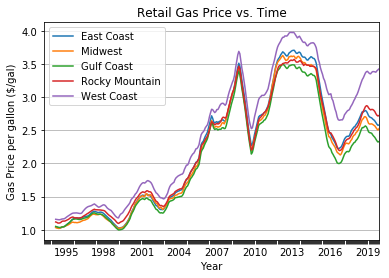

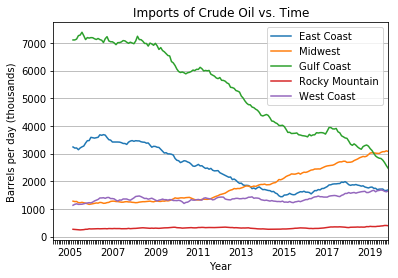

The correlation of import: {'East Coast': array([0.22467687]), 'Midwest': array([0.19544598]), 'Gulf Coast': array([0.28617818]), 'Rocky Mountain': array([0.30784727]), 'West Coast': array([0.28821779])}


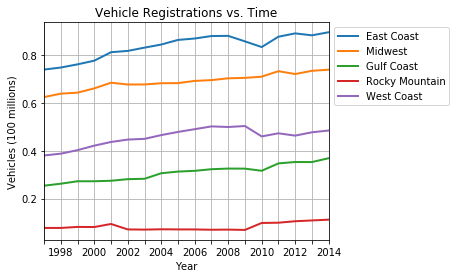

The correlation of vehicles: {'East Coast': array([0.39729393]), 'Midwest': array([0.35936974]), 'Gulf Coast': array([0.32582077]), 'Rocky Mountain': array([0.2276593]), 'West Coast': array([0.37308347])}


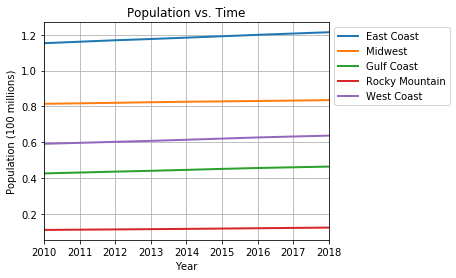

Correlation of populations: {'East Coast': array([0.20563774]), 'Midwest': array([0.21333798]), 'Gulf Coast': array([0.20272939]), 'Rocky Mountain': array([0.2001929]), 'West Coast': array([0.22166776])}


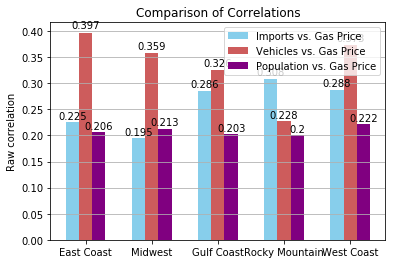

In [4]:
if __name__ == "__main__":
    gas_price = {}
    price_dict, import_dict, stock_dict, export_dict, refine_dict  = {}, {}, {}, {}, {}

    #store url
    for i, r in enumerate(Region):
        price_dict[r] = price_url.replace('10', '%d') %(10*(i+1))
        import_dict[r] = import_url.replace('10', '%d') %(10*(i+1))

    #load url
    df_price = dict2df(price_dict).div(1000)
    df_import = dict2df_im(import_dict)

    #plot price figure using rolling mean
    price_fig = df_price.rolling(12).mean().plot.line(title= 'Retail Gas Price vs. Time')
    df_price.index = pd.to_datetime(df_price.index)
    start_year = df_price.index[0].year
    end_year = df_price.index[-1].year
    positions = []
    for p in df_price.index:
        if p.year == start_year and p.month == 1:
            positions.append(str(p.year))
        elif p.year == end_year and p.month == 1:
            positions.append(str(p.year))            
        elif p.month == 1  and p.year % 3 == 0:
            positions.append(str(p.year))
        else:
            positions.append(str(''))
    price_fig.set_xticks(range(len(positions)))
    price_fig.set_xticklabels(positions)
    price_fig.set_xlabel("Year")
    price_fig.set_ylabel("Gas Price per gallon ($/gal)")
    price_fig.grid(axis = 'y')
    plt.show()

    #plot import figure using rolling mean
    import_fig = df_import.rolling(12).mean().plot.line(title = 'Imports of Crude Oil vs. Time')
    df_import.index = pd.to_datetime(df_import.index)
    positions = []
    for p in df_import.index:
        if p.year == start_year and p.month == 1:
            positions.append(str(p.year))
        elif p.year == end_year and p.month == 1:
            positions.append(str(p.year))            
        elif p.month == 1  and p.year % 2 == 1:
            positions.append(str(p.year))
        else:
            positions.append(str(''))
    import_fig.set_xticks(range(len(positions)))
    import_fig.set_xticklabels(positions)
    import_fig.set_xlabel("Year")
    import_fig.set_ylabel("Barrels per day (thousands)")
    import_fig.grid(axis = 'y')
    plt.show() 
    
    #derive the correlation 
    import_cor = get_correlate(df_price, df_import)
    print('The correlation of import:', import_cor)
    
    #build the correlation map
    import_corr_map = create_corr_map(import_cor)
    title = 'Correlation of \nImports vs. Gas Price'
#     create_heatmap(import_corr_map, plt.cm.Oranges, title)

    #%%
    #load the vehicles data
    df_vehicle = load_vehicle(18)

    #plot the vehicle figure
    ve_fig = df_vehicle.plot.line(title = 'Vehicle Registrations vs. Time', grid = True, lw = 2)
    df_vehicle.index = pd.to_datetime(df_vehicle.index)
    positions = []
    for p in df_vehicle.index:         
        if p.month == 1  and p.year % 2 == 0:
            positions.append(str(p.year))
        else:
            positions.append(str(''))
    box = ve_fig.get_position()
    ve_fig.set_position([box.x0, box.y0, box.width*0.85, box.height])
    ve_fig.set_xticks(range(len(positions)))
    ve_fig.set_xticklabels(positions)    
    ve_fig.set_xlabel("Year")
    ve_fig.set_ylabel("Vehicles (100 millions)")    
    ve_fig.legend(bbox_to_anchor=(1,1))
    plt.show()    
    df_price_down = downsample(df_price, int(df_vehicle.index[0].year), int(df_vehicle.index[-1].year))
    
    #derive the correlation 
    vehicle_cor = get_correlate(df_price_down, df_vehicle)    
    print('The correlation of vehicles:', vehicle_cor)

    #build the map
    vehicle_corr_map = create_corr_map(vehicle_cor)
    title = 'Correlation of \nVehicle Registrations vs. Gas Price'
#     create_heatmap(vehicle_corr_map, plt.cm.Greens, title)    
    
    #%%
    #load the populations data    
    df_population = load_population(population_path)

    #plot the population data
    pop_fig = df_population.plot.line(title = 'Population vs. Time', grid = True, lw = 2)
    df_population.index = pd.to_datetime(df_population.index)
    positions = [p.year for p in df_population.index if p.month == 1]
    box = pop_fig.get_position()
    pop_fig.set_position([box.x0, box.y0, box.width*0.85, box.height])
    pop_fig.set_xticklabels(positions)    
    pop_fig.set_xlabel("Year")
    pop_fig.set_ylabel("Population (100 millions)")
    pop_fig.legend(bbox_to_anchor=(1,1))
    plt.show()    
    df_price_down = downsample(df_price, int(df_population.index[0].year), int(df_population.index[-1].year))
    
    #derive the correlation
    pop_cor = get_correlate(df_price_down, df_population) 
    print('Correlation of populations:', pop_cor)
    
    #build the correlation map
    pop_corr_map = create_corr_map(pop_cor)
    title = 'Correlation of \nPopulation vs. Gas Price'
#     create_heatmap(pop_corr_map, plt.cm.Blues, title)
    
    #build the bar graph
    bar_chart=corr_bar(import_cor,vehicle_cor,pop_cor)    



In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

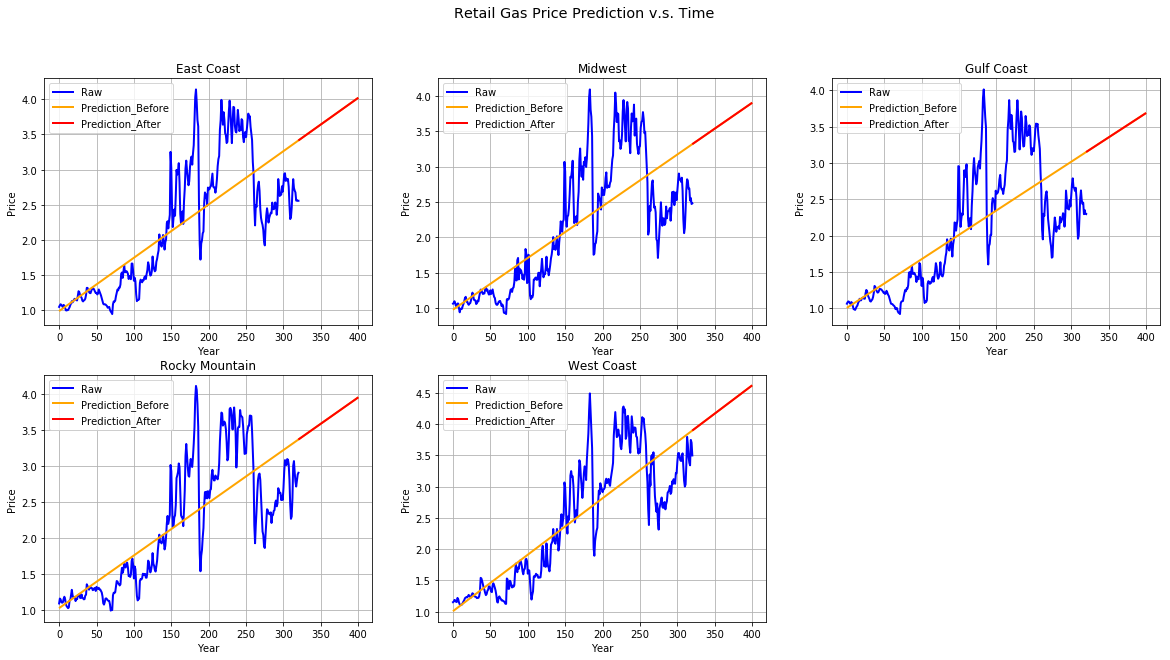

In [12]:
x_test = np.array([i for i in range(321,400)]).reshape(-1,1)
x_train = np.array([i for i in range(len(df_price))]).reshape(-1,1)
x_range = np.array([i for i in range(1,400)]).reshape(-1,1)
palette = plt.get_cmap('Set1')
fig = plt.figure(figsize=(20,10))
st = fig.suptitle("Retail Gas Price Prediction v.s. Time", fontsize="x-large")
for num,i in enumerate(Region):
    regressor = LinearRegression()  
    regressor.fit(x_train,df_price[i].values.reshape(-1,1))
    y_pred = regressor.predict(x_test)
#     plot_x = np.concatenate((df_price[i].values.reshape(-1,1),y_pred),axis=0)
#     plt.plot(x_range,plot_x, markersize=2, color=palette(num), linewidth=2, label='Raw')
    y_pred_all = regressor.predict(x_range)
    plt.subplot(2,3,num+1)
    plt.plot(x_train,df_price[i].values.reshape(-1,1), markersize=2, color='blue', linewidth=2, label='Raw')
    plt.plot(x_range,y_pred_all, markersize=2, color='orange', linewidth=2, label='Prediction_Before')
    plt.plot(x_test,y_pred, markersize=2, color='red', linewidth=2, label='Prediction_After')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.title('{}'.format(Region[num]))
    plt.grid()
    plt.legend()
plt.show()


In [ ]:
df_price.values